# About dataset:-
The dataset contains set of SMS messages in English of 5,572 messages, tagged acording being ham (legitimate) or spam. The associated problem is that, we have to train a model using textual message that classfy the messages in "spam" or "ham" using NLP(Natural language processing).

In [1]:
# IMPORTING LIBRARIES
import nltk
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import numpy as np

In [2]:
# VIEWING ROW DATAFILE 
message = [line.rstrip() for line in open('data/SMSSpamCollection')]
message[0]
#The rstrip() method removes any trailing characters (characters at the end a string), 
#space is the default trailing character to remove.

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

#### Note:-

The file is in tab-separated format, if we see the above message the word ham and Go is separated by a tab, in which ham is the class and Go is a word from message.

In [3]:
# IMPORTING DATASET
messages = pd.read_csv("data/SMSSpamCollection",sep='\t', names=["label","message"])
#Importing dataset of csv format in dataframe of pandas with column names "label" contains class of messages(ham or spam) 
#and "message" column name contains the actual message. 


In [4]:
# DATA OVERVIEW 
messages.head()
#.head() gives the first 5 rows of dataframe.

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# DATA OVERVIEW                                    
messages.groupby('label').describe()
#.describe() gives the brief stats about the data.

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

### INSIGHTS
The spam class has a count of 4825 in which 4516 are unique, while in ham class we have count of 747 of which 653 are unique. This means we have duplicacy in our data and even the classes are imbalanced(which is rather not major problem).

In [7]:
#We add a column named "length" which contains the lenght of message and dropping dublicates.
messages["length"] = messages["message"].apply(len)
messages = messages.drop_duplicates(subset=None, keep='first', inplace=False)
messages.count()

label      5169
message    5169
length     5169
dtype: int64

We dropped the duplicate rows in our dataset. now we have total 5169 messages in our data set.

### EXPLORATORY DATA ANALYSIS

In [7]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [8]:
# check the count and percentage of SPAM AND HAM in data set.

#labels
lab = messages["label"].value_counts().keys().tolist() # gives classes i.e. spam or ham
#values
val = messages["label"].value_counts().values.tolist() # gives count of classes 

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "label distribution in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

In our dataset we have 87.4% ham(4516 in counts) and 12.6% spam(653 in counts), hence we will apply the model for whole dataset and for dataset containing equal count of classes to see the difference of class imbalance in any.

In [16]:
## Function to return string length

def get_sentence_length(sentence):
    return len(sentence.split(' '))

In [26]:
## df.apply operation on the 'spam' and 'ham' dataframes

spam['length'] = spam['message'].apply(lambda x: get_sentence_length(x))
ham['length'] = ham['message'].apply(lambda x: get_sentence_length(x))

C:\Users\Tanush Pas\AppData\Local\conda\conda\envs\PDF\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Tanush Pas\AppData\Local\conda\conda\envs\PDF\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [32]:
## df.apply operation on 'messages' dataframe
messages['length'] = messages['message'].apply(lambda x: get_sentence_length(x))

In [33]:
# lenght wise distribution based on label
spam    = messages[messages["label"] == "spam"]
ham = messages[messages["label"] == "ham"]


trace1 = go.Histogram(x  = spam["length"],
                          histnorm= "percent",
                          name = "% spam",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
trace2 = go.Histogram(x  = ham["length"],
                          histnorm = "percent",
                          name = "% ham",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
layout = go.Layout(dict(title ="lenght wise distribution based on label ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "length of words",
                                             zerolinewidth=2,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

### Insights
From the above graph we can see that approx 75 percent of spam message is of length 132-162. And above 50 pecent of ham message is of lenght 22-52.From this we can say that spam messages are slightly lengthy than ham messages.

## Required Pre-processing

In [34]:
#Tokenization(converting normal text strings into tokens and tokens are just cleaned version of words we want)
# The below function will remove punctuation , remove stopwords and return list of clean text words.

def text_process(mess):

    clean =[char for char in mess if char not in string.punctuation]
    clean = ''.join(clean)
    return [word for word in clean.split() if word.lower() not in stopwords.words('english')]

# getting  viewing the list of tokens.
messages["message"].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [35]:
# Creating BAG OF WORDS(bow) by converting this list of tokens into vectors so that our ML algorithms can be applicable.
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages["message"])

#checking the count of words in our vocabulary
print(len(bow_transformer.vocabulary_))

11425


After tokenization and vectorization we have 11425 number of unique words in our bag of words.

### MODEL BUILDING

In [36]:
# Spliting the dataset into training and testing in 70:30 ratio respectively
msg_train,msg_test,label_train,label_test = train_test_split(messages['message'],messages['label'],test_size = 0.3,random_state=0)

### CONCEPT OF TF-IDF
Term Frequency (tf): gives us the frequency of the word in each document in the corpus. It is the ratio of number of times the word appears in a document compared to the total number of words in that document.

Inverse Data Frequency (idf): used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score.

The combination these two we come up with the TF-IDF score (w) for a word in a document in the corpus. It is the product of tf and idf:

                     W(i,j) = TF(i,j) * log(N/df(i))


                    TF(i,j) = no of occurance of i in j
                    df(i)   = no of document containing i
                    N       = total no of documents

In [37]:
# Creating a pipeline function 

pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),# doing pre-processing and vectorization
    ('tfidf',TfidfTransformer()),# assigning TF-IDF, creating TDM
    ('classifier',MultinomialNB())# applying NaiveBayes classifier
])

In [38]:
# Applying pipeline function to training data
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000025A0CDAC268>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [39]:
# using pipeline for prediction
predictions = pipeline.predict(msg_test)

[[ 164   57]
 [   0 1451]]


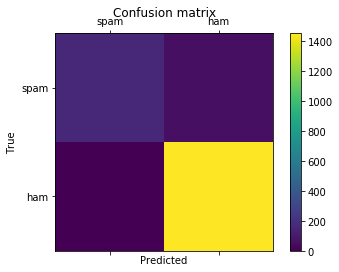

In [40]:
# Generating confusion matrix
#cm = confusion_matrix(label_test, predictions, labels=["spam","ham"], sample_weight=None)
#cm
labels = ["spam","ham"]
cm = confusion_matrix(label_test, predictions, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Description
True positive and true negatives are the observations that are correctly predicted which are given in quadrant 2nd and 4th, which are 136 and 1350 in values(refer cm).

False positives nd false negatives is the condition when actual class contradicts with the predicted class,false negatives are given in 1st quadrant and false positive are given in 3rd quadrant, which are 65 and 0 in values resceptively(refer cm).

In our case :-

TP ---- predicted spam and were spam = 136

FP ---- predicted spam and were ham = 0

TN ---- predicted ham and were ham = 1350

FN ---- predicted ham and were spam = 65

In [41]:
# Generating classification report
print (classification_report(label_test,predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1451
        spam       1.00      0.74      0.85       221

    accuracy                           0.97      1672
   macro avg       0.98      0.87      0.92      1672
weighted avg       0.97      0.97      0.96      1672



### Description
Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. (Precision = TP/TP+FP)

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class. (Recall = TP/TP+FN)

F1 score - F1 Score is the weighted average of Precision and Recall.

Given By -------- f1-score = 2(Recall Precision) / (Recall + Precision) 

In [42]:
# Calculating the Accuracy of the model.
accuracy_score(label_test, predictions, normalize=True, sample_weight=None)

0.9659090909090909

### Description
Accuracy - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations.

Accuracy = TP+TN/TP+FP+FN+TN

We have 95.8% of accuracy in our model.



## Improve model performance

In [43]:
### Getting the dataframe contains columns:-
# message            -- messsage of mes_test data
# ham_prob,spam_prob -- naive bayes assigned probability to be ham or spam
# predicted          -- as predicted by NB classifier
# label              -- actual class
predict = pd.DataFrame(predictions,index=None)
predict.columns = ["predicted"]

msg_test_1 = pd.DataFrame(msg_test)
msg_test_1 = msg_test_1.reset_index(drop=True)

label_test_1 = pd.DataFrame(label_test)
label_test_1 = label_test_1.reset_index(drop=True)

NB_prob = pd.DataFrame(pipeline.predict_proba(msg_test))
NB_prob.columns = ["ham_prob","spam_prob"]

df = pd.concat([msg_test_1,NB_prob,predict,label_test_1],axis=1,sort=False)
df["length"] = df["message"].apply(len)# Adding lenth column to df
df.head()

,message,ham_prob,spam_prob,predicted,label,length
0,"Storming msg: Wen u lift d phne, u say ""HELLO""...",0.978957,0.021043,ham,ham,324
1,<Forwarded from 448712404000>Please CALL 08712...,0.512734,0.487266,ham,spam,111
2,And also I've sorta blown him off a couple tim...,0.986100,0.013900,ham,ham,116
3,"Sir Goodmorning, Once free call me.",0.933851,0.066149,ham,ham,35
4,All will come alive.better correct any good lo...,0.982663,0.017337,ham,ham,73


# Insights
Above dataframe contains the information of messages of test set(msg_test) as message, probability of that message to be classified as ham as ham_prob, probability of that message to be classified as spam as spam_prob (as accoding to naive bayes), predicted class of message as predicted (through naive bayes), actual class of that message as label and length column containg the length of that message as length.

## Adjust the decision threshold to identify the operating point
To set the decision threshold of the model to maximize either sensitivity or specificity. This is called the “operating point” of the model.

In [44]:
# Creating required functions

le = preprocessing.LabelEncoder()
y_test = le.fit_transform(label_test_1)
y_scores = pipeline.predict_proba(msg_test)[:, 1]

p, r, thresholds = precision_recall_curve(y_test, y_scores)

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.9):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_ham', 'pred_spam'], 
                       index=['actual_ham', 'actual_spam']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
markersize=15)

C:\Users\Tanush Pas\AppData\Local\conda\conda\envs\PDF\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



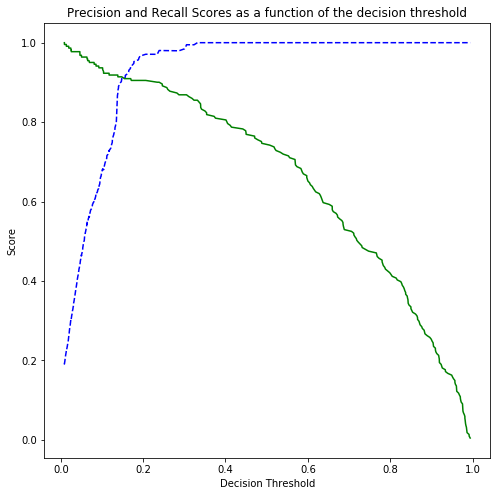

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
#plt.legend(loc='best')

plot_precision_recall_vs_threshold(p, r, thresholds)

# Insights
From the above graph we can see that as the threshod increases precision increases and recall decreases, the intersection of precision and recall is the trade-off point in our case that point occurs when threshold value is near about 0.1

The trade-off point is the point where we have balanced values of precision and recall, that means both of the classes are classified equally, there is no baisness of model to classify a particular class, this biasness is removed by assigning the value of threshold.

             pred_ham  pred_spam
actual_ham       1329        122
actual_spam        13        208


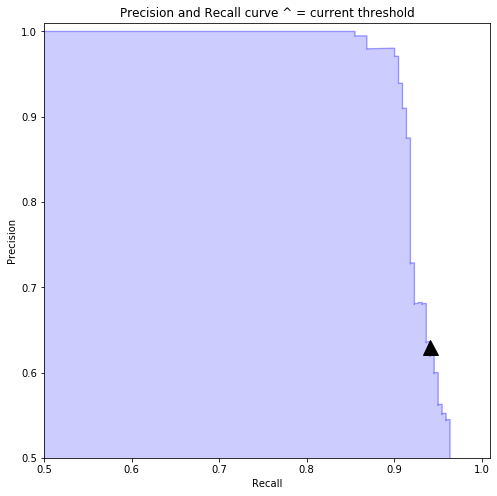

In [46]:
# Getting confusion matrix after applying threshold.
precision_recall_threshold(p, r, thresholds, .09) 

# Insights
After setting threshold as 0.09 i.e. the ratio of recall and precision as 0.09 our model is able to predict the spam as well.

 Out of 201 spams our model predicted 189 spams correctly
                         &
 Out of 1350 hams our model predicted 1234 hams correctly

### Model Evaluation
Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. (Precision = TP/TP+FP)

----------------Precision(ham)  = 1234/(1234 + 12) == 0.99-----------------
----------------Precision(spam) = 189/(189 + 116)  == 0.61-----------------

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class. (Recall = TP/TP+FN)

----------------Recall(ham)   = 1234/(1234 + 116) == 0.91-----------------
----------------Recall(spam)  = 189/(189 + 12)    == 0.94-----------------


F1 score - F1 Score is the weighted average of Precision and Recall.

Given By -------- f1-score = 2(Recall * Precision) / (Recall + Precision)

----------------F1 score(ham)   = 2(.91)(.99) / (.91 + .99) == 0.94-----------------
----------------F1 score(spam)  = 2(.94)(.61) / (.94 + .61) == 0.74-----------------


### Description
Accuracy - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations.

Accuracy = TP+TN/TP+FP+FN+TN

We have 91.7% of accuracy in our model.


# Improving model by assigning probability in favour of spam class.

In [47]:
# Creating a pipeline function 

pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),# doing pre-processing and vectorization
    ('tfidf',TfidfTransformer()),# assigning TF-IDF, creating TDM
    ('classifier',MultinomialNB(class_prior=[0.35, 0.65]))# applying NaiveBayes classifier with biased probability
])


In [48]:
# Applying pipeline function to training data with biased probability
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000025A0CDAC268>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=[0.35, 0.65],
                               fit_prior

In [49]:
# using pipeline for prediction with biased probability
predictions = pipeline.predict(msg_test)

[[ 210   11]
 [ 143 1308]]


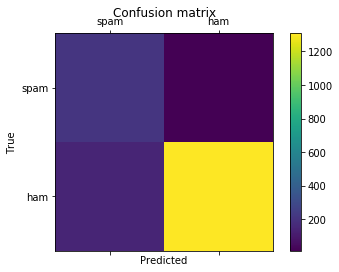

In [50]:
# Generating confusion matrix of actual & predictions with biased probability
labels = ["spam","ham"]
cm = confusion_matrix(label_test, predictions, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Insights
After setting probability to classes our model is able to predict the spam as well.

Out of 201 spams our model predicted 189 spams correctly

                     &

Out of 1350 hams our model predicted 1184 hams correctly

In [51]:
# Generating classification report
print (classification_report(label_test,predictions))

              precision    recall  f1-score   support

         ham       0.99      0.90      0.94      1451
        spam       0.59      0.95      0.73       221

    accuracy                           0.91      1672
   macro avg       0.79      0.93      0.84      1672
weighted avg       0.94      0.91      0.92      1672



In [52]:
# Calculating the Accuracy of the model.
accuracy_score(label_test, predictions, normalize=True, sample_weight=None)

0.9078947368421053